In [5]:
!pip install sentencepiece

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
import pandas as pd


en_train_path = '/content/drive/MyDrive/Transformer_Bert/data/raw/en/train.txt'
en_val_path = '/content/drive/MyDrive/Transformer_Bert/data/raw/en/val.txt'
fr_train_path = '/content/drive/MyDrive/Transformer_Bert/data/raw/fr/train.txt'
fr_val_path = '/content/drive/MyDrive/Transformer_Bert/data/raw/fr/val.txt'

df_en_train = pd.read_table(en_train_path)
df_fr_train = pd.read_table(fr_train_path)


df_train = pd.DataFrame(columns = ['English', 'French'])

df_train['English'] = df_en_train
df_train['French'] = df_fr_train

df_train


,English,French
0,Hi.,Salut !
1,Hi.,Salut.
2,Run!,Cours !
3,Run!,Courez !
4,Who?,Qui ?
...,...,...
136514,His request was equivalent to an order.,Ses désirs étaient des ordres.
136515,His sudden appearance surprised us all.,Sa subite apparition nous surprit tous.
136516,History is more complex than you think.,L'Histoire est plus compliquée que tu ne penses.
136517,History is more complex than you think.,L'Histoire est plus compliquée que vous ne pen...


In [9]:
train = df_train.to_numpy()

src_train, trg_train = train[:,0], train[:,1]

print("SRC train shape: {}; TRG train shape: {}".format(src_train.shape, trg_train.shape))


SRC train shape: (136519,); TRG train shape: (136519,)


In [10]:
import sentencepiece as spm

spm.SentencePieceTrainer.Train(sentence_iterator=iter(src_train),                                 # Load dataset
                               pad_id=0, bos_id=1, eos_id=2, unk_id=3,
                               vocab_size = 5000,
                               model_prefix = "/content/drive/MyDrive/Transformer_Bert/trained_models/tokenizer/english",
                               model_type = 'bpe')

spm.SentencePieceTrainer.Train(sentence_iterator=iter(trg_train),                                 # Load dataset
                               pad_id=0, bos_id=1, eos_id=2, unk_id=3,
                               vocab_size = 5000,
                               model_prefix = "/content/drive/MyDrive/Transformer_Bert/trained_models/tokenizer/french",
                               model_type = 'bpe')


In [11]:

english = spm.SentencePieceProcessor(model_file = "/content/drive/MyDrive/Transformer_Bert/trained_models/tokenizer/english.model")
src_train_tok = english.EncodeAsIds(list(src_train))

french = spm.SentencePieceProcessor(model_file = "/content/drive/MyDrive/Transformer_Bert/trained_models/tokenizer/french.model")
trg_train_tok = french.EncodeAsIds(list(trg_train))


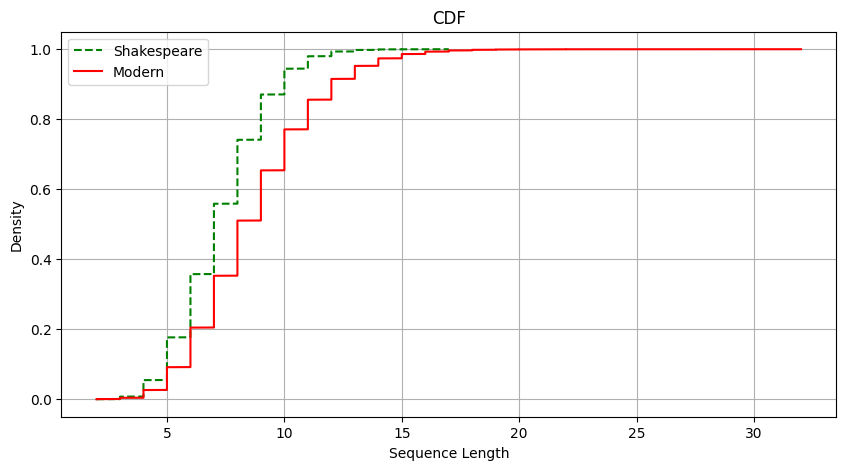

In [12]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import numpy as np
plt.rcParams["figure.figsize"] = (10,5)
# Let's see what length distribution of sentences in both src and trg
src_train_len = []
trg_train_len = []

for (src_snt, trg_snt) in zip(src_train_tok, trg_train_tok):
    src_train_len.append(len(src_snt)) # Store len of an individual src
    trg_train_len.append(len(trg_snt)) # Store len of an individual trg

plt.plot(np.sort(src_train_len), np.arange(len(src_train_len))/len(src_train_len), label="Shakespeare", linestyle="--", color="green")
plt.plot(np.sort(trg_train_len), np.arange(len(trg_train_len))/len(trg_train_len), label="Modern", color="red")
plt.grid()
plt.xlabel("Sequence Length")
plt.ylabel("Density")
plt.legend()
plt.title("CDF")

plt.show()

In [13]:
max_seq_len = 40

def src_processing(tokens, max_seq_len):
    if len(tokens) < max_seq_len:
        tokens += [2]  # Assuming 2 is the EOS token
        tokens += [0] * (max_seq_len - len(tokens))  # Padding
    else:
        tokens = tokens[:max_seq_len - 1] + [2]
    return tokens

def trg_processing(tokens, max_seq_len):
    tokens = [1] + tokens  # Assuming 1 is the BOS token
    if len(tokens) < max_seq_len:
        tokens += [2]  # EOS token
        tokens += [0] * (max_seq_len - len(tokens))  # Padding
    else:
        tokens = tokens[:max_seq_len - 1] + [2]
    return tokens

def out_decoder(tokens, max_seq_len):
    tokens += [2]  # EOS token
    if len(tokens) < max_seq_len:
        tokens += [0] * (max_seq_len - len(tokens))  # Padding
    else:
        tokens = tokens[:max_seq_len]
    return tokens


In [14]:

src_id = [src_processing(id, max_seq_len) for id in src_train_tok]

input_trg_id = [trg_processing(id, max_seq_len) for id in trg_train_tok]
output_trg_id = [out_decoder(id, max_seq_len) for id in trg_train_tok]

In [15]:
import torch
import torch.nn as nn
from torch.nn import functional as F
src_id = torch.tensor(src_id)
input_trg_id = torch.tensor(input_trg_id)
output_trg_id = torch.tensor(output_trg_id)

print("Src Shapes: {}; dtype: {}".format(src_id.shape, src_id.dtype))
print("Input Trg Shapes: {}; dtype: {}".format(input_trg_id.shape, input_trg_id.dtype))
print("Output Trg Shapes: {}; dtype: {}".format(output_trg_id.shape, output_trg_id.dtype))

Src Shapes: torch.Size([136519, 40]); dtype: torch.int64
Input Trg Shapes: torch.Size([136519, 40]); dtype: torch.int64
Output Trg Shapes: torch.Size([136519, 40]); dtype: torch.int64


In [16]:
n = int(0.9*len(src_id))
print(n)
src_train_data = src_id[:n]
trg_train_data = input_trg_id[:n]

src_val_data = src_id[n:]
trg_val_data = input_trg_id[n:]

print(src_train_data[0:256].shape)
print(trg_train_data.shape)
print(src_val_data.shape)
print(trg_val_data.shape)




122867
torch.Size([256, 40])
torch.Size([122867, 40])
torch.Size([13652, 40])
torch.Size([13652, 40])


In [17]:
torch.manual_seed(1337)
 # how many independent sequences will we process in parallel?
batch_size = 4

def get_batch(split):
    # generate a small batch of data of inputs x and targets y
    if split == 'train':
        indices = np.random.choice(len(src_train_data), batch_size)
        return src_train_data[indices], trg_train_data[indices]
    else:
        indices = np.random.choice(len(src_val_data), batch_size)
        return src_val_data[indices], trg_val_data[indices]

xb, yb = get_batch('train')
print('inputs:')
print(xb.shape)
print(xb)
print('targets:')
print(yb.shape)
print(yb)

print('----')

for b in range(batch_size): # batch dimension
        context = xb[b]
        target = yb[b]
        print(f"when input is  {context.shape} the target: {target.shape}")

inputs:
torch.Size([4, 40])
tensor([[  90,  276,   20, 1097,  658,  293,  346, 4955,    2,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [  58,  196, 1337, 4979, 1220, 4965, 4948,   14, 4972,    2,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [ 713,   45,  494, 4955,    2,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0],
        [ 118, 4965, 4952, 2488, 4955,    2,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    

In [22]:
block_size = 256
max_iters = 2000
eval_interval = 500
learning_rate = 3e-4
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters=200
embd = 512
n_head = 8
n_layer = 6
dropout = 0.3
src_vocab_len = english.vocab_size()
trg_vocab_len = french.vocab_size()
batch_size = 64

def get_batch(dataset, batch_size):
    if dataset == 'train':
        indices = np.random.choice(len(src_train_data), batch_size)
        x = src_train_data[indices]
        y = trg_train_data[indices]
    else:
        indices = np.random.choice(len(src_val_data), batch_size)
        x = src_val_data[indices]
        y = trg_val_data[indices]
    x, y = x.to(device), y.to(device)


    return x[:, :-1], y[:, 1:]

@torch.no_grad()
def estimate_loss(model, criterion, eval_iters=200):
    model.eval()
    losses = {'train': 0, 'val': 0}
    for dataset in ['train', 'val']:
        for _ in range(eval_iters):
            xb, yb = get_batch(dataset, batch_size)
            output = model(xb, yb)
            output = output.reshape(-1, output.size(-1))
            yb = yb.reshape(-1)
            loss = criterion(output, yb)
            losses[dataset] += loss.item()
        losses[dataset] /= eval_iters
    model.train()
    return losses


class MaskedHead(nn.Module):
   def __init__(self, head_size):
      super().__init__()
      self.key = nn.Linear(embd, head_size, bias=False)
      self.query = nn.Linear(embd, head_size, bias=False)
      self.value = nn.Linear(embd, head_size, bias=False)
      self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

      self.dropout = nn.Dropout(dropout)

   def forward(self, x):
      B,T,C = x.shape
      k=self.key(x)
      q=self.query(x)
      wei = q@k.transpose(-2,-1) * C**-0.5
      wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
      wei = F.softmax(wei, dim=-1)
      wei = self.dropout(wei)

      v= self.value(x)
      out = wei@v
      return out

class Head(nn.Module):
   def __init__(self, head_size):
      super().__init__()
      self.key = nn.Linear(embd, head_size, bias=False)
      self.query = nn.Linear(embd, head_size, bias=False)
      self.value = nn.Linear(embd, head_size, bias=False)
      self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

      self.dropout = nn.Dropout(dropout)

   def forward(self, x):
      B,T,C = x.shape
      k=self.key(x)
      q=self.query(x)
      wei = q@k.transpose(-2,-1) * C**-0.5
      #wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
      wei = F.softmax(wei, dim=-1)
      wei = self.dropout(wei)

      v= self.value(x)
      out = wei@v
      return out

class DecoderHead(nn.Module):
   def __init__(self, head_size):
      super().__init__()
      self.key = nn.Linear(embd, head_size, bias=False)
      self.query = nn.Linear(embd, head_size, bias=False)
      self.value = nn.Linear(embd, head_size, bias=False)
      self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

      self.dropout = nn.Dropout(dropout)

   def forward(self, x, y):
      B,T,C = x.shape
      #print("decoder head = ", B)
      k=self.key(y)
      q=self.query(x)
      wei = q@k.transpose(-2,-1) * C**-0.5
      #wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
      wei = F.softmax(wei, dim=-1)
      wei = self.dropout(wei)

      v= self.value(y)
      out = wei@v
      return out


class MaskedMultiHeadAttention(nn.Module):
   def __init__(self, num_heads, head_size):
      super().__init__()
      self.heads = nn.ModuleList([MaskedHead(head_size) for _ in range(num_heads)])
      self.proj = nn.Linear(embd, embd)
      self.dropout = nn.Dropout(dropout)

   def forward(self, x):
      out = torch.cat([h(x) for h in self.heads], dim=-1)
      out = self.dropout(self.proj(out))
      return out

class MultiHeadAttention(torch.nn.Module):
  def __init__(self, num_heads, head_size):
      super().__init__()
      self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
      self.proj = nn.Linear(embd, embd)
      self.dropout = nn.Dropout(dropout)

  def forward(self, x):
      out = torch.cat([h(x) for h in self.heads], dim=-1)
      out = self.dropout(self.proj(out))
      return out

class DecoderMultiHeadAttention(torch.nn.Module):
  def __init__(self, num_heads, head_size):
      super().__init__()
      self.heads = nn.ModuleList([DecoderHead(head_size) for _ in range(num_heads)])
      self.proj = nn.Linear(embd, embd)
      self.dropout = nn.Dropout(dropout)

  def forward(self, x, y):

      out = torch.cat([h(x, y) for h in self.heads], dim=-1)
      out = self.dropout(self.proj(out))
      #print("dsa head = ", out.shape)
      return out

class FeedForward(nn.Module):
   def __init__(self, embd):
      super().__init__()
      self.net = nn.Sequential(
         nn.Linear(embd, 4 * embd),
         nn.ReLU(),
         nn.Linear(4 * embd,embd),
         nn.Dropout(dropout),
      )

   def forward(self, x):
      return self.net(x)


class Encoder(torch.nn.Module):
  def __init__(self, embd, n_head):
    super().__init__()
    head_size = embd//n_head
    self.sa = MultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(embd)
    self.ln1 = nn.LayerNorm(embd)
    self.ln2 = nn.LayerNorm(embd)


  def forward(self, x):
    x = x + self.sa(self.ln1(x))
    x = x + self.ffwd(self.ln2(x))
    return x


class Decoder(torch.nn.Module):
  def __init__(self, embd, n_head):
    super().__init__()
    head_size = embd//n_head
    self.msa = MaskedMultiHeadAttention(n_head, head_size)
    self.dsa = DecoderMultiHeadAttention(n_head, head_size)
    self.ffwd = FeedForward(embd)
    self.ln1 = nn.LayerNorm(embd)
    self.ln2 = nn.LayerNorm(embd)
    self.ln3 = nn.LayerNorm(embd)

  def forward(self, x, e_out):
    #print("x = ", x.shape)
    x = x + self.msa(self.ln1(x))
    #print("msa x = ", x.shape)
    #x = x + self.dsa(self.ln2(x), self.ln2(e_out))
    #print("dsa x = ", x.shape)
    x = x + self.ffwd(self.ln3(x))
    return x, e_out

class mySequential(nn.Sequential):
    def forward(self, *input):
        for module in self._modules.values():
            input = module(*input)
        return input


class Transformer(nn.Module):
    def __init__(self, embd, max_seq_len, src_vocab_len, trg_vocab_len):
        super().__init__()
        self.device = device
        self.src_token_emb = nn.Embedding(src_vocab_len, embd)
        self.trg_token_emb = nn.Embedding(trg_vocab_len, embd)
        self.src_pos_enc = nn.Embedding(max_seq_len, embd)
        self.trg_pos_enc = nn.Embedding(max_seq_len, embd)
        self.encoders = nn.Sequential(*[Encoder(embd, n_head=n_head) for _ in range(n_layer)])
        self.decoders = mySequential(
            Decoder(embd, n_head=n_head),
            Decoder(embd, n_head=n_head),
            Decoder(embd, n_head=n_head),
            Decoder(embd, n_head=n_head),
            Decoder(embd, n_head=n_head),
            Decoder(embd, n_head=n_head),
        )
        self.ln_f = nn.LayerNorm(embd)
        self.lm_head = nn.Linear(embd, trg_vocab_len)
        self.softmax = nn.LogSoftmax(dim=-1)

    def forward(self, src_in, trg_in):
        src_in = self.src_token_emb(src_in)
        b, t, emb = src_in.shape
        src_in += self.src_pos_enc(torch.arange(t, device=src_in.device))[None, :, :]

        x = self.encoders(src_in)
        if trg_in is not None:
            trg_in = self.trg_token_emb(trg_in)
            b, t, emb = trg_in.shape
            trg_in += self.trg_pos_enc(torch.arange(t, device=trg_in.device))[None, :, :]
            y = self.decoders(trg_in, x)
            y = self.ln_f(y[0])
            output = self.lm_head(y)
            output = self.softmax(output)
            return output

        return x
        @torch.no_grad()
    def inference(self, src_tensor, max_seq_len, beam_size=3, temperature=1.0):
        self.eval()
        src_tensor = src_tensor.to(self.device)
        src_emb = self.src_token_emb(src_tensor)
        src_emb += self.src_pos_enc(torch.arange(src_tensor.shape[1], device=self.device))[None, :, :]

        memory = self.encoders(src_emb)

        trg_indices = [[1]]  # Start with the BOS token
        scores = [0.0]

        for _ in range(max_seq_len - 1):
            all_candidates = []
            for i in range(len(trg_indices)):
                trg_tensor = torch.tensor(trg_indices[i], dtype=torch.long, device=self.device).unsqueeze(0)
                trg_emb = self.trg_token_emb(trg_tensor)
                trg_emb += self.trg_pos_enc(torch.arange(len(trg_indices[i]), device=self.device))[None, :, :]

                output = self.decoders(trg_emb, memory)
                output = self.ln_f(output[0])
                output = self.lm_head(output)
                output = F.log_softmax(output[:, -1, :] / temperature, dim=-1)  # Apply temperature
                topk = torch.topk(output, beam_size, dim=-1)

                for k in range(beam_size):
                    candidate = trg_indices[i] + [topk.indices[0, k].item()]
                    candidate_score = scores[i] + topk.values[0, k].item()
                    all_candidates.append((candidate_score, candidate))

            ordered = sorted(all_candidates, key=lambda x: x[0], reverse=True)
            scores, trg_indices = zip(*ordered[:beam_size])

            if trg_indices[0][-1] == 2:  # EOS token
                break

        best_sequence = trg_indices[0]
        best_sequence += [0] * (max_seq_len - len(best_sequence))  # Pad the rest with PAD tokens
        return best_sequence

In [23]:
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
import matplotlib.pyplot as plt

# Initialize the model, criterion, optimizer, and scheduler
model = Transformer(embd=embd, max_seq_len=max_seq_len, src_vocab_len=src_vocab_len, trg_vocab_len=trg_vocab_len).to(device)
criterion = nn.CrossEntropyLoss(ignore_index = 0)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)  # Added weight decay
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5, verbose=True)

# Early stopping parameters
patience = 10
best_val_loss = float('inf')
early_stop_counter = 0

train_losses = []
val_losses = []

for iter in range(max_iters):
    model.train()
    xb, yb = get_batch('train', batch_size)

    # Forward pass
    output = model(xb, yb)

    # Reshape output and yb
    output = output.reshape(-1, trg_vocab_len)
    yb = yb.reshape(-1)
    if iter == 19999:
        print("x = ", xb[0])
        print("y = ", yb[0])
        print("output = ", output[0])
    # Calculate loss
    loss = criterion(output, yb)

    # Backward pass and optimization
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

    if iter % eval_interval == 0 or iter == max_iters - 1:
        model.eval()
        with torch.no_grad():
            losses = estimate_loss(model, criterion)
        val_loss = losses['val']
        train_loss = losses['train']
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        print(f"step {iter}: train loss {train_loss:.4f}, val loss {val_loss:.4f}")

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            early_stop_counter = 0
        else:
            early_stop_counter += 1

        if early_stop_counter >= patience:
            print("Early stopping triggered")
            break

        scheduler.step(val_loss)

/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


step 0: train loss 7.0214, val loss 7.3617
step 500: train loss 0.0852, val loss 0.1283
step 1000: train loss 0.0091, val loss 0.0191
step 1500: train loss 0.0027, val loss 0.0077
step 1999: train loss 0.0013, val loss 0.0035


5
5
5


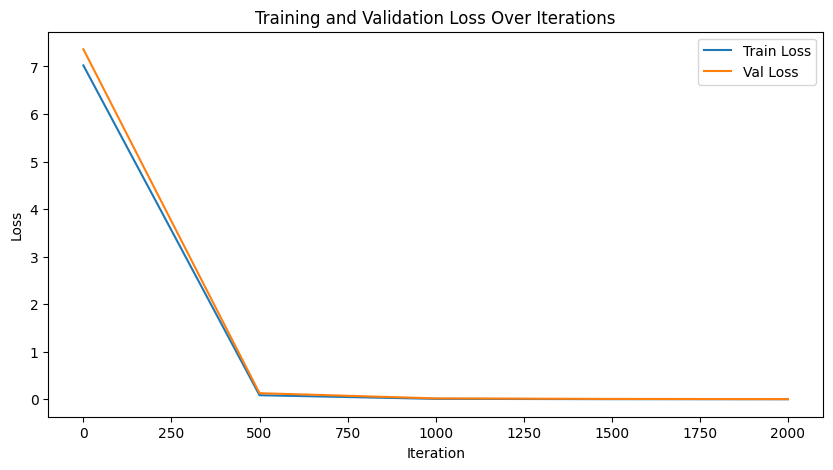

'\n/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.\n  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "\nstep 0: train loss 8.8069, val loss 8.7538\nstep 500: train loss 4.6851, val loss 5.2179\nstep 1000: train loss 4.1986, val loss 4.7704\nstep 1500: train loss 3.9923, val loss 4.5901\nstep 2000: train loss 3.8177, val loss 4.4160\nstep 2500: train loss 3.7085, val loss 4.3033\nstep 3000: train loss 3.6144, val loss 4.2211\nstep 3500: train loss 3.5411, val loss 4.1291\nstep 4000: train loss 3.4560, val loss 4.0512\nstep 4500: train loss 3.4141, val loss 3.9768\nstep 5000: train loss 3.3516, val loss 3.9560\nstep 5500: train loss 3.3088, val loss 3.9039\nstep 6000: train loss 3.2658, val loss 3.8545\nstep 6500: train loss 3.2311, val loss 3.8027\nstep 7000: train loss 3.1786, val loss 3.7757\nstep 7500: train loss 3.1597, val los

In [24]:
# Assuming max_iters and eval_interval are defined
eval_steps = range(0, max_iters + 1, eval_interval)

print(len(train_losses))  # Check the length of train_losses
print(len(val_losses))    # Check the length of val_losses
print(len(eval_steps))
plt.figure(figsize=(10, 5))
plt.plot(eval_steps[:len(train_losses)], train_losses, label='Train Loss')
plt.plot(eval_steps[:len(val_losses)], val_losses, label='Val Loss')
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss Over Iterations')
plt.show()


"""
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
step 0: train loss 8.8069, val loss 8.7538
step 500: train loss 4.6851, val loss 5.2179
step 1000: train loss 4.1986, val loss 4.7704
step 1500: train loss 3.9923, val loss 4.5901
step 2000: train loss 3.8177, val loss 4.4160
step 2500: train loss 3.7085, val loss 4.3033
step 3000: train loss 3.6144, val loss 4.2211
step 3500: train loss 3.5411, val loss 4.1291
step 4000: train loss 3.4560, val loss 4.0512
step 4500: train loss 3.4141, val loss 3.9768
step 5000: train loss 3.3516, val loss 3.9560
step 5500: train loss 3.3088, val loss 3.9039
step 6000: train loss 3.2658, val loss 3.8545
step 6500: train loss 3.2311, val loss 3.8027
step 7000: train loss 3.1786, val loss 3.7757
step 7500: train loss 3.1597, val loss 3.7379
step 8000: train loss 3.1197, val loss 3.7115
step 8500: train loss 3.1110, val loss 3.6886
step 9000: train loss 3.0766, val loss 3.6785
step 9500: train loss 3.0624, val loss 3.6239
step 9999: train loss 3.0422, val loss 3.6278
"""

In [25]:
import sentencepiece as spm

# Load the SentencePiece models
english = spm.SentencePieceProcessor(model_file="/content/drive/MyDrive/Transformer_Bert/trained_models/tokenizer/english.model")
french = spm.SentencePieceProcessor(model_file="/content/drive/MyDrive/Transformer_Bert/trained_models/tokenizer/french.model")

# Tokenize the source sentence
src_sentence = "Hi"
src_tokens = english.EncodeAsIds(src_sentence)
src_tensor = torch.tensor([src_processing(src_tokens, max_seq_len)], dtype=torch.long)
print(src_tensor)

# Perform inference
with torch.no_grad():

    trg_tokens = model.inference(src_tensor, max_seq_len)

print(trg_tokens)
# Decode the output tokens to a sentence
trg_sentence = french.DecodeIds([token for token in trg_tokens if token not in [0, 1, 2]])  # Remove special tokens
print("Translated Sentence:", trg_sentence)


tensor([[4904,    2,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0]])


TypeError: 'float' object is not subscriptable